# Quickstart

Here, we'll go through a very basic example of reconstructing, preprocessing, and visualizing 4D faces from video data using Medusa's Python API. For more information about its command-line interface, check the CLI [documentation](../api/cli)!

We'll use a short video to reconstruct, shown below:

In [1]:
from IPython.display import Video
from medusa.data import get_example_video

# Returns path to an example mp4 file
vid = get_example_video()
print(f"Going to reconstruct {vid.name}!")

# Show in notebook
Video(vid, embed=True)  

Going to reconstruct example_vid.mp4!


## Reconstruction

For this example, we'll use the [Mediapipe Face Mesh](https://google.github.io/mediapipe/solutions/face_mesh.html) model to reconstruct the face in the video in 4D, that is, a 3D reconstruction for each frame of the video. We are going to use the high-level `videorecon` function from Medusa, which reconstructs the video frame by frame and returns a ``Data4D`` object, which contains all reconstruction (meta)data.

In [2]:
from medusa.recon import videorecon
data = videorecon(vid, recon_model='mediapipe', loglevel='WARNING')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Great! Now let's inspect the ``data`` variable. The reconstructed vertices are stored in the attribute `v`, a [PyTorch](https://pytorch.org/) tensor of shape $T$ (time points) $\times\ V$ (vertices) $\times\ 3$ (X, Y, Z).

In [3]:
print("`v` is of type: ", type(data.v))
print("`v` has shape: ", tuple(data.v.shape))

`v` is of type:  <class 'torch.Tensor'>
`v` has shape:  (232, 468, 3)


The the data contained in `v` represents, for each time point, the 3D coordinates of the vertices (also called "landmarks") that describe the shape of the face. The particular mesh used by Mediapipe contains 468 vertices, but other reconstruction models may contain many more vertices (like [FLAME](https://flame.is.tue.mpg.de)-based models, which reconstruct 5023 vertices)!

To get an idea of the data, let's just extract the 3D vertices from the first time point (i.e., the first frame of the video) and plot it. We need to do this in 2D, of course, so we'll just a scatterplot to visualize the X and Y coordinates only:  

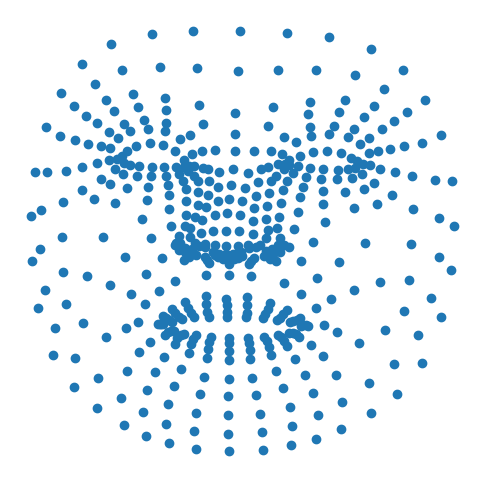

In [4]:
import matplotlib.pyplot as plt
v = data.v.cpu().numpy()  # move data from torch to numpy!
t0 = v[0, :, :]  # first time point
t0_x = t0[:, 0]
t0_y = t0[:, 1]

plt.figure(figsize=(6, 6), )
plt.scatter(t0_x, t0_y)
plt.axis('off')
plt.show()

A more appealing way to visualize the reconstruction is as a "wireframe". Medusa allows you to do this for all time points, such that it creates a video of the full 4D reconstruction, and (optionally) rendered on top of the original video as well. To do so, you can use the ``render_video`` method that each data object in Medusa has. 

We do this below. By setting the `video` parameter to the path of the video, we tell the `render_video` method to render the wireframe on top of the original video:

In [5]:
from medusa.render import VideoRenderer

renderer = VideoRenderer(shading='flat')
f_out = './example_vid_recon.mp4'
renderer(f_out, data, video=vid)

# Show in notebook
Video(f_out, embed=True)

That looks pretty good! However, there are two issues with the data as it is now. First, each vertex represents both "global" (rigid) movement (i.e., the face moving left/right/up/down and rotating) and "local" (non-rigid) information (i.e., facial expressions such as smiling and frowning). Second, part of these rigid movements seem to reflect noisy "jitter", which are simply inaccuracies in the reconstruction.

## Alignment

We can separate global and local movement by *aligning* the reconstructions across time. Alignment, here, refers to the rotation and translation necessary to match the reconstructed vertices from each timepoint to a reference timepoint or template. The alignment parameters were already estimated during reconstruction and are stored in the `.mat` attribute of the data object, a tensor of shape $T \times 4 \times 4$, representing a $4 \times 4$ affine matrix for each of the $T$ timepoints.

In [ ]:
tuple(data.mat.shape)

Before alignment, the data is in so-called "world space". After alignment to a template mesh (centered at the origin of its local coordinate system), the data is in "local space". To move the data between these two spaces, you can use the `to_local` method (which projects out global motion) and `to_world` methods (which adds global motion back in). 

Let's get rid of the global motion and see what the reconstruction now looks like:

In [ ]:
data.to_local()

f_out = './example_vid_recon.mp4'
renderer = VideoRenderer(shading='flat')
renderer(f_out, data)

Video(f_out, embed=True)

Importantly, we can convert this matrix representation of global motion to a set of translation and rotation parameters (and shear and scale parameters, which we ignore for now) that are easier to interpret. To do this, you can use the `decompose_mats` method:

In [ ]:
# Decompose affine matrices to movement parameters
motion_params = data.decompose_mats()

# Select translation and rotation only (ignore shear/scale)
motion_params = motion_params.iloc[:, :6]

# Show first five time points (i.e., video frames)
motion_params.head()

Just like the vertices, these parameters can be interpreted as time series representing the rigid movement of the face over time:

In [ ]:
# Show movement relative to first timepoint
motion_params = motion_params - motion_params.iloc[0, :]
trans_params = motion_params.iloc[:, :3]
rot_params = motion_params.iloc[:, 3:]

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
axes[0].plot(trans_params)
axes[0].set_ylabel('Translation (in mm.)', fontsize=15)
axes[0].set_xlim(0, motion_params.shape[0])
axes[1].plot(rot_params)
axes[1].set_ylabel('Rotation (in deg.)', fontsize=15)
axes[1].set_xlabel('Frame nr.', fontsize=15)
axes[1].legend(['X', 'Y', 'Z'], frameon=False, ncol=3, fontsize=15)
fig.show()

There is a lot more functionality in Medusa, including different reconstruction models, preprocessing functions, and analysis options. A great way to explore this is to check out the tutorials. A good starting point is the [4D reconstruction](../tutorials/reconstruction) tutorial. Or browse through the [Python API reference](../api/python)!